<a href="https://colab.research.google.com/github/alimurrofid/Machine-Learning-Kelas-3E/blob/main/24%20Sabna%20Devi%20Kumalasari/Jobsheet10/Praktikum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Jobsheet 10: Recurrent Neural Network (RNN)**
- Nama   : Sabna Devi Kumalasari
- NIM    : 2141720009
- Kelas  : 3E D4-TI

## **Praktikum 1 - RNN untuk Analisis Sentimen**

### **Setup**
Impor matplotlib dan buat fungsi pembantu untuk memplot grafik:

In [ ]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar() #digunakan untuk menonaktifkan tampilan progress bar saat menggunakan TensorFlow Datasets (TFDS)

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric]) #membuat plot nilai metrik yang spesifik
  plt.plot(history.history['val_'+metric], '') #membuat plot nilai yang sama untuk metrik yang sama pada dataset validasi
  plt.xlabel("Epochs")
  plt.ylabel(metric) #Menetapkan label untuk sumbu y sesuai dengan metrik yang dipilih, yang diberikan sebagai argumen kepada fungsi.
  plt.legend([metric, 'val_'+metric]) #menambahkan legenda ke plot. Legenda membantu membedakan antara garis pelatihan dan validasi dengan memberi label dengan nama metrik

### **Setup input pipeline**

Dataset ulasan film IMDB adalah kumpulan data klasifikasi biner—semua ulasan memiliki sentimen positif atau negatif.

Download dataset menggunakan [TFDS](https://www.tensorflow.org/datasets). Lihat [loading text tutorial](https://www.tensorflow.org/tutorials/load_data/text) jika ingin me load data secara manual

In [ ]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Awalnya ini mengembalikan dataset (teks, pasangan label):

In [ ]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Berikutnya acak data untuk pelatihan dan membuat kumpulan pasangan (teks, label) ini:

In [ ]:
BUFFER_SIZE = 10000 #digunakan dalam proses pengacakan (shuffling) dataset
BATCH_SIZE = 64 #menentukan seberapa banyak data yang akan digunakan dalam satu iterasi pelatihan model

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])


texts:  [b'Currently on METOO\'s new schedule at 4 pm on weekdays, right after "Maverick" and right before "Wild, Wild West" (followed by "Star Trek").<br /><br />Don\'t know if I ever actually saw an episode of it when it was originally on, but I\'m really captivated by it. Offbeat, unusual, surreal stories set in a mythical West. Kind of the "Naked City" of Westerns.<br /><br />And the guest stars are there: Dan Duryea, Lyle Bettger, Brian Donlevy, MacDonald Carey, Rick Jason (as a treacherous Mexican), a young Dick Van Patten, Jack Lord, Noah Berry, Jr. (as a colorful Mexican), Martha Hyer, Marguerite Chapman, even Ann Robinson ("War of the Worlds"), Gloria Talbott ("I Married a Monster from Outer Space")<br /><br />It ran for EIGHT SEASONS, over 200 episodes, from January, 1959, to December, 1965.<br /><br />Eric Fleming is quite remarkable as trail boss Gil Favor, the most stolid man that\'s ever lived, with the code of honor of a Samurai, and just the right balance between toughn

### **Buat Teks Encoder**

Teks mentah yang dimuat oleh tfds perlu diproses sebelum dapat digunakan dalam model. Cara termudah memproses teks untuk pelatihan adalah menggunakan lapisan TextVectorization. Lapisan ini memiliki banyak kemampuan, namun pada tutorial ini menggunakan perilaku default. Buat lapisan tersebut, dan teruskan teks kumpulan data ke metode .adapt lapisan:

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE) #digunakan untuk mengubah teks menjadi representasi vektor yang dapat digunakan oleh model NLP
encoder.adapt(train_dataset.map(lambda text, label: text)) # digunakan untuk mengadaptasi (mempersiapkan) layer TextVectorization dengan dataset pelatihan

Metode .adapt mengatur kosakata lapisan. 20 token pertama dapat dilihat dengan kode berikut. Setelah padding dan token yang tidak diketahui, mereka diurutkan berdasarkan frekuensi:

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Setelah kosakata diatur, lapisan dapat mengkodekan teks ke dalam indeks. Tensor indeks diberi bantalan 0 ke urutan terpanjang dalam batch (kecuali jika Anda menetapkan output_sequence_length tetap):

In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  1,  21,   1, ...,   0,   0,   0],
       [ 47, 227,   1, ...,   0,   0,   0],
       [ 51,  34, 288, ...,   0,   0,   0]])

Dengan pengaturan default, prosesnya tidak dapat dibalik sepenuhnya. Ada dua alasan utama untuk itu:

- Nilai default untuk argumen standarisasi preprocessing.TextVectorization adalah "lower_and_strip_punctuation".
- Ukuran kosa kata yang terbatas dan kurangnya fallback berbasis karakter menghasilkan beberapa token yang tidak diketahui.

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'Currently on METOO\'s new schedule at 4 pm on weekdays, right after "Maverick" and right before "Wild, Wild West" (followed by "Star Trek").<br /><br />Don\'t know if I ever actually saw an episode of it when it was originally on, but I\'m really captivated by it. Offbeat, unusual, surreal stories set in a mythical West. Kind of the "Naked City" of Westerns.<br /><br />And the guest stars are there: Dan Duryea, Lyle Bettger, Brian Donlevy, MacDonald Carey, Rick Jason (as a treacherous Mexican), a young Dick Van Patten, Jack Lord, Noah Berry, Jr. (as a colorful Mexican), Martha Hyer, Marguerite Chapman, even Ann Robinson ("War of the Worlds"), Gloria Talbott ("I Married a Monster from Outer Space")<br /><br />It ran for EIGHT SEASONS, over 200 episodes, from January, 1959, to December, 1965.<br /><br />Eric Fleming is quite remarkable as trail boss Gil Favor, the most stolid man that\'s ever lived, with the code of honor of a Samurai, and just the right balance between toug

### **Buat Model**

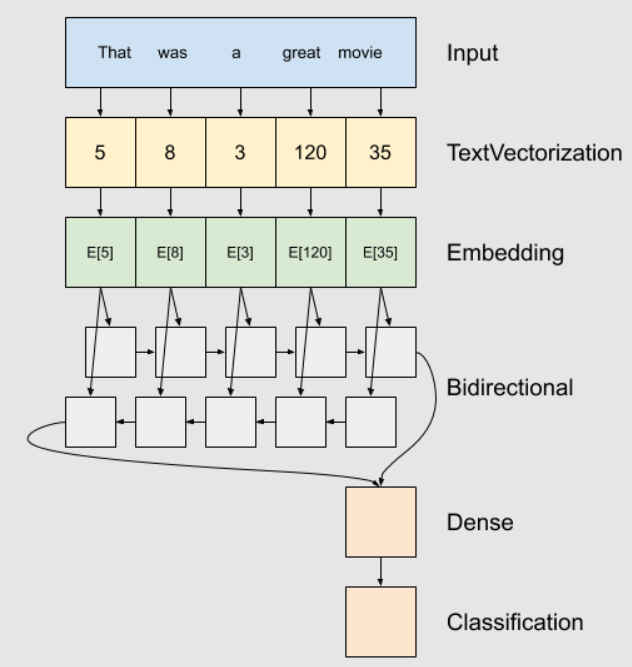


1. Model ini dapat dibuat sebagai tf.keras.Sequential.
2. Lapisan pertama adalah encoder, yang mengubah teks menjadi urutan indeks token.
3. Setelah encoder adalah lapisan penyematan (embedding layer). Lapisan penyematan menyimpan satu vektor per kata. Saat dipanggil, ini mengubah rangkaian indeks kata menjadi rangkaian vektor. Vektor-vektor ini dapat dilatih. Setelah pelatihan (dengan data yang cukup), kata-kata dengan arti yang mirip sering kali memiliki vektor yang serupa. Pencarian indeks ini jauh lebih efisien daripada operasi setara dengan meneruskan vektor yang disandikan one-hot melalui lapisan tf.keras.layers.Dense.
4. Jaringan saraf berulang (RNN) memproses masukan urutan dengan melakukan iterasi melalui elemen. RNN meneruskan keluaran dari satu langkah waktu ke masukannya pada langkah waktu berikutnya.
Pembungkus tf.keras.layers.Bidirection juga dapat digunakan dengan lapisan RNN. Ini menyebarkan masukan maju dan mundur melalui lapisan RNN dan kemudian menggabungkan keluaran akhir.
  - Keuntungan utama RNN dua arah adalah sinyal dari awal masukan tidak perlu diproses sepanjang waktu untuk memengaruhi keluaran.
  - Kerugian utama dari RNN dua arah adalah Anda tidak dapat melakukan streaming prediksi secara efisien saat kata-kata ditambahkan di akhir.
5. Setelah RNN mengonversi urutan menjadi satu vektor, kedua lapisan tersebut.Dense melakukan beberapa pemrosesan akhir, dan mengonversi representasi vektor ini menjadi logit tunggal sebagai keluaran klasifikasi.

Kode nya adalah sebagai berikut :

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Harap dicatat bahwa model sekuensial Keras digunakan di sini karena semua lapisan dalam model hanya memiliki masukan tunggal dan menghasilkan keluaran tunggal. Jika Anda ingin menggunakan lapisan RNN stateful, Anda mungkin ingin membangun model Anda dengan API fungsional Keras atau subkelas model sehingga Anda dapat mengambil dan menggunakan kembali status lapisan RNN. Untuk detailnya bisa dilihat pada [Keras RNN guide](https://www.tensorflow.org/guide/keras/working_with_rnns#rnn_state_reuse)

Lapisan penyematan menggunakan masking ([uses masking](https://www.tensorflow.org/guide/keras/understanding_masking_and_padding) ) untuk menangani panjang urutan yang bervariasi. Semua lapisan setelah penyematan dukungan penyematan

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


Untuk memastikan bahwa ini berfungsi seperti yang diharapkan, evaluasi sebuah kalimat dua kali. Pertama, satu kalimat sehingga tidak ada bantalan (padding) untuk disamarkan:

In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 3s 3s/step
[0.00428106]


Sekarang, evaluasi lagi dalam batch dengan kalimat yang lebih panjang. Hasilnya harus sama:

In [ ]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 277ms/step
[0.00428106]


compile model Keras untuk mengonfigurasi proses pelatihan:

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

### **Train Model**

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 710s 2s/step - loss: 0.6437 - accuracy: 0.5692 - val_loss: 0.5180 - val_accuracy: 0.7365
Epoch 2/10
391/391 [==============================] - 673s 2s/step - loss: 0.4351 - accuracy: 0.8024 - val_loss: 0.4066 - val_accuracy: 0.8297
Epoch 3/10
391/391 [==============================] - 678s 2s/step - loss: 0.3669 - accuracy: 0.8381 - val_loss: 0.3583 - val_accuracy: 0.8464
Epoch 4/10
391/391 [==============================] - 666s 2s/step - loss: 0.3371 - accuracy: 0.8547 - val_loss: 0.3396 - val_accuracy: 0.8479
Epoch 5/10
391/391 [==============================] - 685s 2s/step - loss: 0.3225 - accuracy: 0.8617 - val_loss: 0.3402 - val_accuracy: 0.8427
Epoch 6/10
391/391 [==============================] - 671s 2s/step - loss: 0.3129 - accuracy: 0.8655 - val_loss: 0.3262 - val_accuracy: 0.8568
Epoch 7/10
391/391 [==============================] - 691s 2s/step - loss: 0.3080 - accuracy: 0.8690 - val_loss: 0.3251 - val_accuracy: 0.8573

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 157s 401ms/step - loss: 0.3164 - accuracy: 0.8628
Test Loss: 0.31638145446777344
Test Accuracy: 0.8628000020980835


(0.0, 0.6609940618276596)

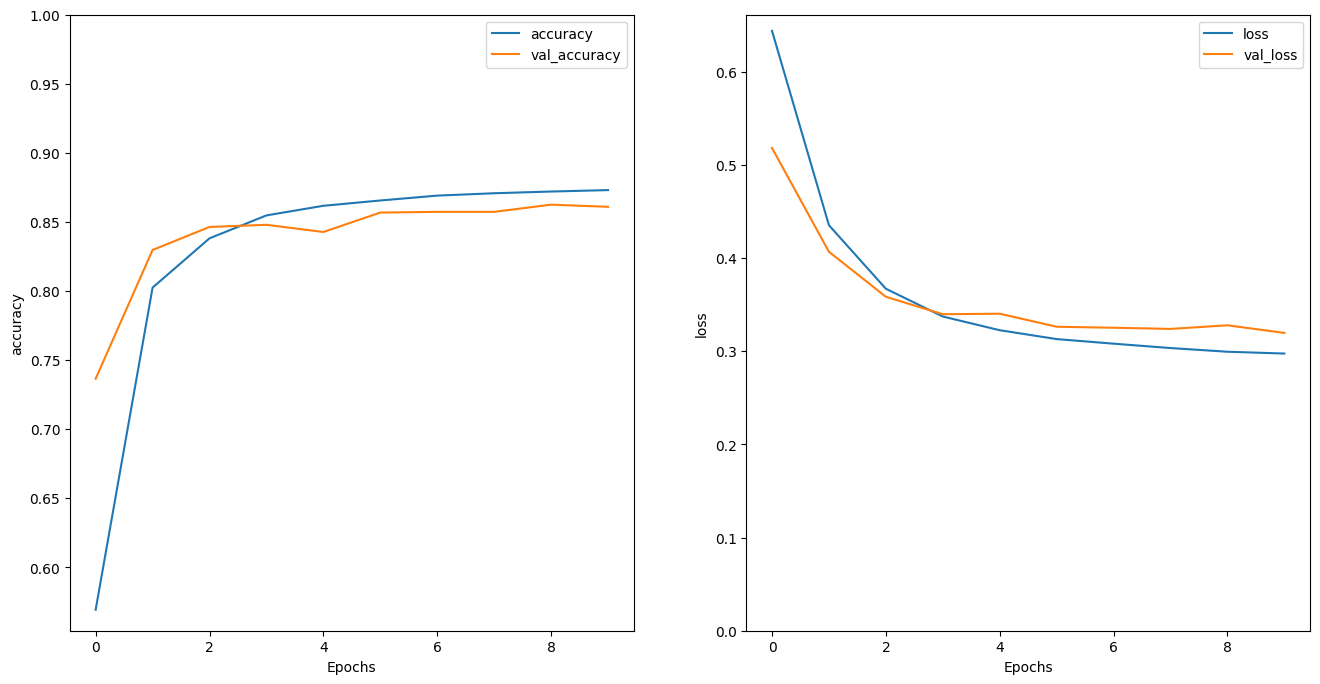

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Jalankan prediksi pada kalimat baru:

Jika prediksi >= 0,0 berarti positif, jika tidak maka negatif.

In [ ]:
sample_text = ('The movie was cool. The animation and the graphics '
              'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 3s 3s/step


### **Stack two or more LSTM layers**

Lapisan berulang Keras memiliki dua mode yang tersedia yang dikontrol oleh argumen konstruktor return_sequences :

- Jika False, ia hanya mengembalikan keluaran terakhir untuk setiap urutan masukan (bentuk tensor 2D (batch_size, output_features)). Ini adalah default yang digunakan pada model sebelumnya.
- Jika True, Sequence lengkap output berturut-turut untuk setiap langkah waktu dikembalikan (bentuk tensor 3D (ukuran_batch, langkah waktu, fitur_output)).

Berikut adalah alur informasi dengan
return_sequences=True:
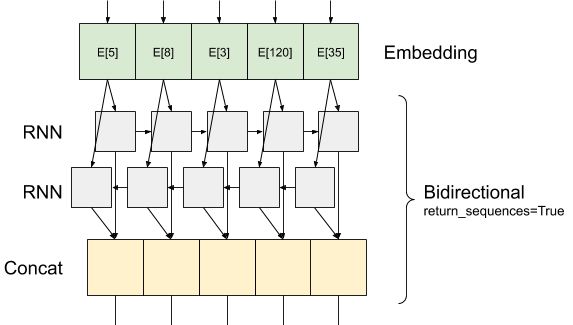

Hal yang menarik dari penggunaan RNN dengan return_sequences=True adalah outputnya masih memiliki 3 axis, sama seperti inputnya, sehingga bisa diteruskan ke layer RNN lain, seperti ini:

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 1347s 3s/step - loss: 0.6229 - accuracy: 0.5964 - val_loss: 0.4262 - val_accuracy: 0.8083
Epoch 2/10
391/391 [==============================] - 1346s 3s/step - loss: 0.3819 - accuracy: 0.8312 - val_loss: 0.3908 - val_accuracy: 0.7906
Epoch 3/10
391/391 [==============================] - 1351s 3s/step - loss: 0.3343 - accuracy: 0.8539 - val_loss: 0.3325 - val_accuracy: 0.8547
Epoch 4/10
391/391 [==============================] - 1306s 3s/step - loss: 0.3219 - accuracy: 0.8628 - val_loss: 0.3392 - val_accuracy: 0.8365
Epoch 5/10
391/391 [==============================] - 1304s 3s/step - loss: 0.3114 - accuracy: 0.8664 - val_loss: 0.3200 - val_accuracy: 0.8542
Epoch 6/10
391/391 [==============================] - 1337s 3s/step - loss: 0.3098 - accuracy: 0.8639 - val_loss: 0.3265 - val_accuracy: 0.8438
Epoch 7/10
391/391 [==============================] - 1314s 3s/step - loss: 0.3050 - accuracy: 0.8672 - val_loss: 0.3287 - val_accuracy:

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 290s 742ms/step - loss: 0.3188 - accuracy: 0.8629
Test Loss: 0.3187711834907532
Test Accuracy: 0.8629199862480164


In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 10s 10s/step
[[-1.7649838]]


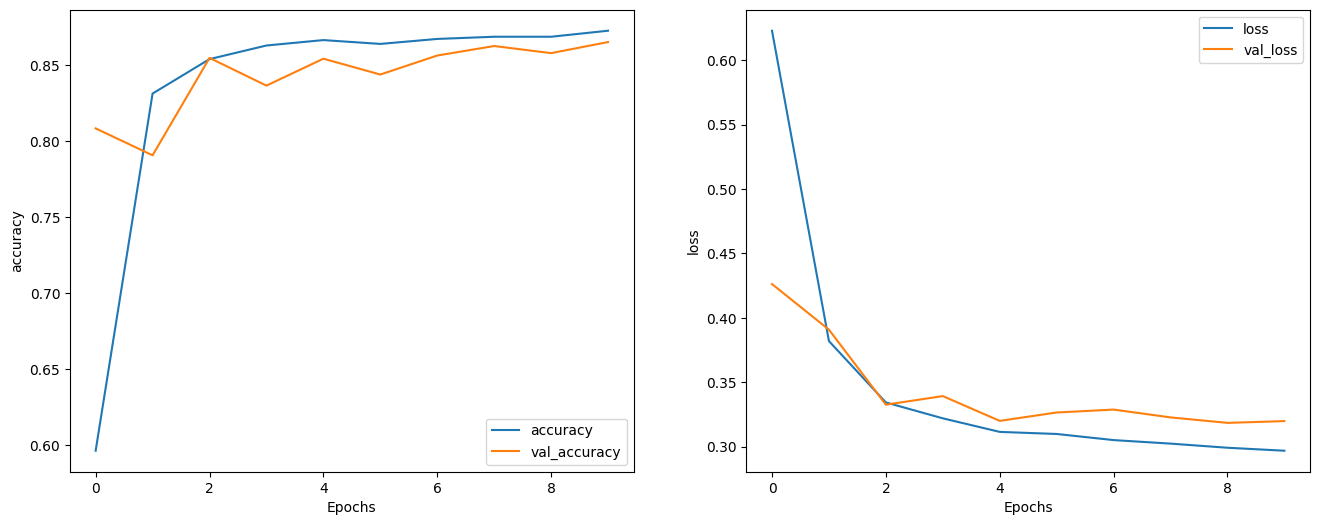

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

## **Catatan**

Informasi menarik lain terkait dengan [GRU layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU).

Informasi membuat custom RNN --> Keras [RNN Guide](https://www.tensorflow.org/guide/keras/working_with_rnns).

## **Praktikum 2 -Generator Teks dengan RNN**

### **Setup**

In [ ]:
import tensorflow as tf
import numpy as np
import os
import time

### **Download Dataset Shakespeare**
Sesuaikan dengan lokasi data yang Anda punya.

In [ ]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

1115394/1115394 [==============================] - 0s 0us/step


### **Load Data**

In [ ]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


In [ ]:
# Take a look at the first 250 characters in text
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [ ]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

65 unique characters


### **Olah Teks**
**Vectorize Teks**
Sebelum training, Anda perlu mengonversi string menjadi representasi numerik. **tf.keras.layers.StringLookup** dapat mengubah setiap karakter menjadi ID numerik. Caranya adalah teks akan dipecah menjadi token terlebih dahulu.

In [ ]:
example_texts = ['abcdefg', 'xyz']
chars = tf.strings.unicode_split(example_texts, input_encoding='UTF-8')
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

sekarang buat tf.keras.layers.StringLookup layer:

In [ ]:
ids_from_chars = tf.keras.layers.StringLookup(
vocabulary=list(vocab), mask_token=None)

perintah diatas mengconvert token menjadi id

In [ ]:
ids = ids_from_chars(chars)
ids

<tf.RaggedTensor [[40, 41, 42, 43, 44, 45, 46], [63, 64, 65]]>

Karena tujuan tutorial ini adalah untuk menghasilkan teks, penting juga untuk membalikkan representasi ini. Untuk ini Anda dapat menggunakan kode tf.keras.layers.StringLookup(..., invert=True).

Catatan: pada kode ini, daripada meneruskan kosakata asli yang dihasilkan dengan diurutkan(set(teks)) gunakan metode get_vocabulary() dari tf.keras.layers.StringLookup sehingga token [UNK] disetel dengan cara yang sama.

In [ ]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

Lapisan ini mengconvert kembali karakter dari vektor ID, dan mengembalikannya sebagai karakter tf.RaggedTensor:

In [ ]:
chars = chars_from_ids(ids)
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

Anda dapat menggunakan tf.strings.reduce_join untuk menggabungkan kembali karakter menjadi string.

In [ ]:
tf.strings.reduce_join(chars, axis=-1).numpy()

array([b'abcdefg', b'xyz'], dtype=object)

In [ ]:
def text_from_ids(ids):
    return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

**Prediksi**

### **Membuat Trianing Set dan Target**

Selanjutnya bagilah teks menjadi contoh sequence. Setiap masukan sequence akan berisi karakter seq_length dari teks. Untuk setiap masukan sequence, target prediksi berisi teks dengan panjang yang sama, hanya digeser satu karakter ke kanan. Jadi, bagi teks menjadi beberapa bagian seq_length+1. Misalnya, seq_length adalah 4 dan teks kita adalah "Hello". Urutan masukannya adalah "Hell", dan urutan targetnya adalah "ello". Untuk melakukan ini, pertama-tama gunakan fungsi tf.data.Dataset.from_tensor_slices untuk mengonversi vektor teks menjadi aliran indeks karakter.

In [ ]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1])>

In [ ]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [ ]:
for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

F
i
r
s
t
 
C
i
t
i


In [ ]:
seq_length = 100

Metode batch memungkinkan Anda dengan mudah mengonversi karakter individual ini menjadi urutan ukuran yang diinginkan.

In [ ]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


akan lebih mudah untuk melihat apa yang dilakukan jika Anda menggabungkan token kembali menjadi string:

In [ ]:
for seq in sequences.take(5):
    print(text_from_ids(seq).numpy())

b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
b'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


Untuk pelatihan, Anda memerlukan kumpulan data pasangan (input, label). Dimana input dan label merupakan urutan. Pada setiap langkah waktu, inputnya adalah karakter saat ini dan labelnya adalah karakter berikutnya. Berikut adalah fungsi yang mengambil urutan sebagai masukan, menduplikasi, dan menggesernya untuk menyelaraskan masukan dan label untuk setiap langkah waktu:

In [ ]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [ ]:
split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [ ]:
dataset = sequences.map(split_input_target)

In [ ]:
for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


### **Membuat Batch Training**

Anda menggunakan tf.data untuk membagi teks menjadi sequence yang dapat diatur. Namun sebelum memasukkan data ini ke dalam model, Anda perlu mengacak data dan mengemasnya ke dalam batch.

In [ ]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

### **Buat Model**

Bagian ini mendefinisikan model sebagai subkelas keras.Model (untuk lebih detilnya, lihat [Making new Layers and Models via subclassing](https://www.tensorflow.org/guide/keras/making_new_layers_and_models_via_subclassing)).

Model yang kita bangun memiliki 3 lapisan neural network :

- tf.keras.layers.Embedding: Lapisan masukan. Tabel pencarian yang dapat dilatih yang akan memetakan setiap karakter-ID ke vektor dengan dimensi embedding_dim;
- tf.keras.layers.GRU: lapisan RNN dengan ukuran unit=rnn_units (Anda juga dapat menggunakan lapisan LSTM di sini.)
- tf.keras.layers.Dense: Lapisan keluaran, dengan keluaran vocab_size. Ini menghasilkan satu logit untuk setiap karakter dalam kosakata. Ini adalah log kemungkinan setiap karakter menurut model.

In [ ]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [ ]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [ ]:
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

Untuk setiap karakter, model mencari penyematan, menjalankan GRU satu langkah waktu dengan penyematan sebagai masukan, dan menerapkan dense layer untuk menghasilkan log yang memprediksi kemungkinan log karakter berikutnya:

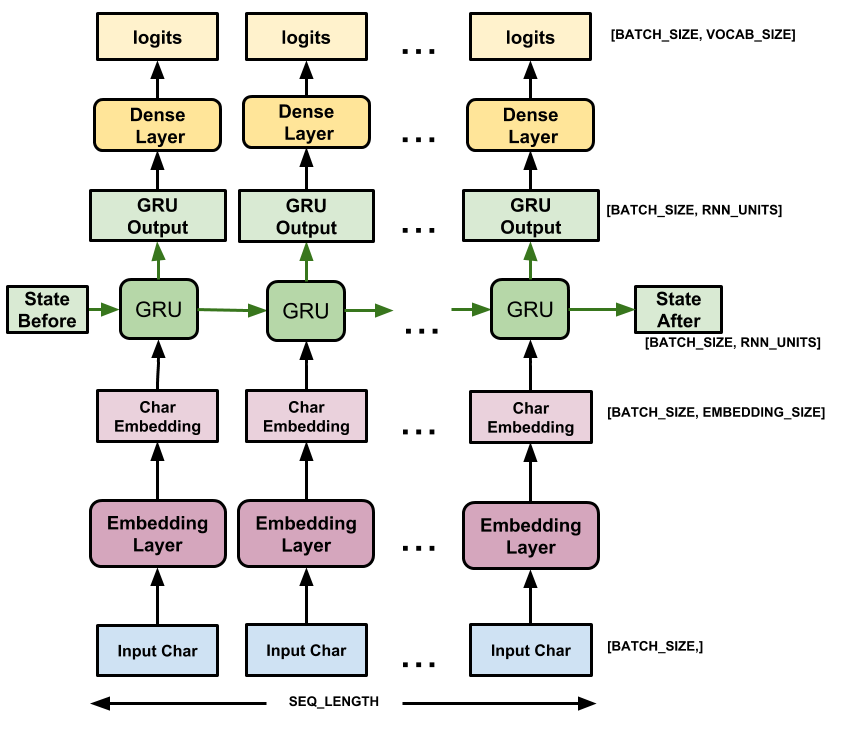

Note: Untuk pelatihan Anda bisa menggunakan model keras.Sequential di sini. Untuk menghasilkan teks nanti, Anda harus mengelola status internal RNN. Akan lebih mudah untuk memasukkan opsi input dan output status di awal, daripada mengatur ulang arsitektur model nanti. untuk detailnya bisa dilihat [Keras RNN guide](https://www.tensorflow.org/guide/keras/working_with_rnns#rnn_state_reuse).

### **Uji Model**


In [ ]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 66) # (batch_size, sequence_length, vocab_size)


Dalam contoh di atas, panjang urutan masukan adalah 100 tetapi model dapat dijalankan pada masukan dengan panjang berapa pun:

In [ ]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  16896     
                                                                 
 gru (GRU)                   multiple                  3938304   
                                                                 
 dense (Dense)               multiple                  67650     
                                                                 
Total params: 4022850 (15.35 MB)
Trainable params: 4022850 (15.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Untuk mendapatkan prediksi aktual dari model, Anda perlu mengambil sampel dari distribusi keluaran, untuk mendapatkan indeks karakter aktual. Distribusi ini ditentukan oleh logit pada kosakata karakter. Catatan: Penting untuk mengambil sampel dari distribusi ini karena mengambil argmax dari distribusi tersebut dapat dengan mudah membuat model terjebak dalam infinote loop. Cobalah untuk contoh pertama di batch:

In [ ]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

Hal ini memberi kita, pada setiap langkah waktu, prediksi indeks karakter berikutnya:

In [ ]:
sampled_indices

array([22, 26, 54, 17, 53, 10, 14, 32, 64, 25, 61,  3, 52, 25, 49, 52, 41,
       44, 40, 33,  8, 55, 65, 53, 33, 32, 31,  4, 61, 33, 61, 29, 28, 50,
       21,  2, 41,  3, 40, 46,  7, 46, 18, 50, 57,  4,  4,  8, 19, 18, 64,
       12,  7,  7, 17,  2, 22, 23, 34,  7, 35, 11, 42, 48,  4, 24, 57, 28,
       19, 40, 11, 33, 42, 58, 42, 46, 53, 24, 39, 28, 62, 35, 42, 45, 40,
       52, 36, 18, 24, 61, 55, 34, 30, 52, 20, 65, 50, 41, 45, 32])

Dekode kode berikut untuk melihat teks yang diprediksi oleh model tidak terlatih ini:

In [ ]:
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

Input:
 b"hat is hardly borne\nBy any in this presence, I desire\nTo reconcile me to his friendly peace:\n'Tis de"

Next Char Predictions:
 b'IMoDn3ASyLv!mLjmbeaT-pznTSR$vTvPOkH b!ag,gEkr$$-FEy;,,D IJU,V:ci$KrOFa:TcscgnKZOwVcfamWEKvpUQmGzkbfS'


### **Train Model**

Pada titik ini permasalahan dapat dianggap sebagai permasalahan klasifikasi standar. Permasalahan dapat disimpulkan dengan : Berdasarkan status RNN sebelumnya, dan masukan langkah kali ini, prediksi kelas karakter berikutnya.

**Tambahan optimizer dan fungsi loss**

loss function tf.keras.losses.sparse_categorical_crossentropy standar berfungsi dalam kasus ini karena diterapkan di seluruh dimensi terakhir prediksi. Karena model Anda mengembalikan logits, Anda perlu mengatur flag from_logits.

In [ ]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 100, 66)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.1893883, shape=(), dtype=float32)


Model yang baru diinisialisasi tidak boleh terlalu yakin dengan dirinya sendiri, semua log keluaran harus memiliki besaran yang sama. Untuk mengonfirmasi hal ini, Anda dapat memeriksa bahwa eksponensial dari loss rata-rata harus kira-kira sama dengan ukuran kosakata. Loss yang jauh lebih tinggi berarti model tersebut yakin akan jawaban yang salah, dan memiliki inisialisasi yang buruk:

In [ ]:
tf.exp(example_batch_mean_loss).numpy()

65.982414

Konfigurasikan prosedur pelatihan menggunakan metode tf.keras.Model.compile. Gunakan tf.keras.optimizers.Adam dengan argumen default dan fungsi loss.

In [ ]:
model.compile(optimizer='adam', loss=loss)

### **Konfigurasi Checkpoints**

Gunakan tf.keras.callbacks.ModelCheckpoint untuk memastikan bahwa checkpoint disimpan selama pelatihan:

In [ ]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

### **Lakukan Proses Training**

Agar waktu pelatihan tidak terlalu lama, gunakan 10 epoch untuk melatih model. Di Colab, setel runtime ke GPU untuk pelatihan yang lebih cepat.

In [ ]:
EPOCHS = 20

In [ ]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/20
172/172 [==============================] - 872s 5s/step - loss: 2.7358
Epoch 2/20
172/172 [==============================] - 889s 5s/step - loss: 2.0044
Epoch 3/20
172/172 [==============================] - 871s 5s/step - loss: 1.7256
Epoch 4/20
172/172 [==============================] - 891s 5s/step - loss: 1.5610
Epoch 5/20
172/172 [==============================] - 877s 5s/step - loss: 1.4597
Epoch 6/20
172/172 [==============================] - 873s 5s/step - loss: 1.3903
Epoch 7/20
172/172 [==============================] - 875s 5s/step - loss: 1.3368
Epoch 8/20
172/172 [==============================] - 872s 5s/step - loss: 1.2905
Epoch 9/20
172/172 [==============================] - 876s 5s/step - loss: 1.2500
Epoch 10/20
114/172 [==================>...........] - ETA: 4:56 - loss: 1.2051

KeyboardInterrupt: ignored

### **Generate Teks**

Cara termudah untuk menghasilkan teks dengan model ini adalah dengan menjalankannya dalam loop, dan menyimpan status internal model saat Anda menjalankannya.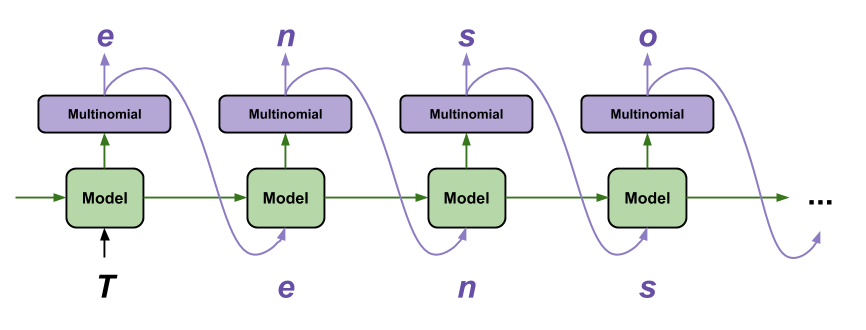

Setiap kali Anda memanggil model, Anda memasukkan beberapa teks dan state internal. Model mengembalikan prediksi untuk karakter berikutnya dan state barunya. Masukkan kembali prediksi dan state ke model untuk terus menghasilkan teks.

In [ ]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [ ]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

Jalankan secara berulang untuk menghasilkan beberapa teks. Melihat teks yang dihasilkan, Anda akan melihat model mengetahui kapan harus menggunakan huruf besar, membuat paragraf, dan meniru kosakata menulis seperti Shakespeare. Karena sedikitnya jumlah epoch pelatihan, model belum belajar membentuk kalimat runtut.

In [ ]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

ROMEO:
Tulls, I shall advertise.

PETRUCHIO:
Who thoughtersorter with age might here?

SICIIIIA:
It were ourselves?
He tongue hand! what shall command me.

Messenger:
Let's go the house: our general, complish,
The mapory Grumion of a
lover and the asedested from
And hearts you to their Edward, friends, even from
me. revenging, is a day--our best limis so unfopative,
And yet not well shall shame ever say
The Mariane weeps of sechet and flattered with love!
What thou art as I provided by Edward's sight;
That keep upon her infectiman:
She is Kath rain, but this is not a dangerous royalty,
And than the day that fears his place; and
Master Bancabour's daughter: I know

BIONDELLO:
I take it is: I had ristom'd then.

HASTINGS:
I may datchful seeming.

MENENIUS:
Rathle, if you pruy me hear?

VOLUMNIA:
Let me speak away!

CLIFFORD:
My mannert sets that fair brows were brother
By badded for thy ground, before it is guilty of
Angels.

Second Citizen:
One fairest kind and place all till thee!
Adva

Hal termudah yang dapat Anda lakukan untuk meningkatkan hasil adalah dengan melatihnya lebih lama (coba EPOCHS = 30). Anda juga dapat bereksperimen dengan string awal yang berbeda, mencoba menambahkan lapisan RNN lain untuk meningkatkan akurasi model, atau menyesuaikan parameter suhu untuk menghasilkan prediksi yang kurang lebih acak.
Jika Anda ingin model menghasilkan teks lebih cepat, hal termudah yang dapat Anda lakukan adalah membuat teks secara batch. Pada contoh di bawah, model menghasilkan 5 keluaran dalam waktu yang hampir sama dengan waktu yang dibutuhkan untuk menghasilkan 1 keluaran di atas.

In [ ]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result, '\n\n' + '_'*80)
print('\nRun time:', end - start)

tf.Tensor(
[b"ROMEO:\nThat, thou hast love it; or mine, embrace,\nAnd leave her joyful owery, look'st thou are.\n\nHASTINGS:\nGood my lord, Canst thou we know not thy knees,\nThe way is giolding to Menenius gentle:\nLucentio such seizing, as to you,\nwhere I part it, I see and man;\nWould not in fortune of holy upheme\nIs three he himself! I say I see in Warwick.\n\nKING RICHARD III:\nMearuse our halves. Ha! be thy hate,\nTo the county my brother; and then, I see this war\nIn thrive I did: speak his oration out\nBeing false day should discivelior,\nMakes thee speak.\n\nESCALUS:\nI go: the wind of England promise\nAs that show them insolditant,\nWhen very neverd come hither flies.\n\nSEBASTIAN:\nWas it here vere thy fourteen hasty\nBride will our lustiness and questioned as yourself,\nLevis, no traitor, shall come away for your counsel:\nCall cold way flouds amiss'd.\n\nDUKE OF YORK:\nI am in Rome taste of you go about it.\n\nHENRY BOLINGBROKE:\nI was a more than mean of most fire\nIncl

### **Ekspor Model Generator**

Model satu langkah ini dapat dengan mudah disimpan dan digunakan kembali, memungkinkan Anda menggunakannya di mana pun tf.saved_model diterima.

In [ ]:
tf.saved_model.save(one_step_model, 'one_step')
one_step_reloaded = tf.saved_model.load('one_step')

In [ ]:
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(100):
  next_char, states = one_step_reloaded.generate_one_step(next_char, states=states)
  result.append(next_char)

print(tf.strings.join(result)[0].numpy().decode("utf-8"))

ROMEO:
Thou art worthy Marcius starve as fector,
Hath blessed me, ladies' befall the
straw with an. Warwic
